# Evaluación de métodos de recuperación en TFM_RAG_NOR


## Índice

1. [Introducción y objetivos](#1-introducción-y-objetivos)
2. [Carga de datos y preparación](#2-carga-de-datos-y-preparación)
3. [Implementación del sistema de recuperación y evaluación de resultados](#3-implementación-del-sistema-de-recuperación-y-evaluación-de-resultados)
4. [Conclusiones de los resultados](#4-Conclusiones-de-los-resultados)

---

## 1. Introducción y objetivos

En este bloque se comparan varios métodos de recuperación de información aplicados a documentos normativos extensos, usando un benchmark manual de queries sobre el corpus TFM_RAG_NOR.  
El objetivo es medir y analizar el rendimiento de BM25, SBERT MiniLM, SBERT MPNet y posibles combinaciones híbridas.

---

## 2. Carga de datos y preparación

Se cargan las queries y los identificadores de los chunks relevantes desde el archivo qa_eval_set.json.


In [97]:
# Cargar benchmark de evaluación (queries y chunks relevantes)
with open('../data/eval/qa_eval_set.json', 'r', encoding='utf-8') as f:
    qa_eval_set = json.load(f)

# Cargar metadatos de los chunks (PDF, página, etc.)
with open('../data/chunks/metadata.json', 'r', encoding='utf-8') as f:
    chunk_metadata = json.load(f)

# Cargar listas de textos y sus IDs (deben ir en el mismo orden que los embeddings)
with open('../data/chunks/texts.json', 'r', encoding='utf-8') as f:
    chunk_texts = json.load(f)
with open('../data/chunks/ids.json', 'r', encoding='utf-8') as f:
    chunk_ids = json.load(f)

# Cargar índice BM25
with open('../data/bm25/bm25_index.pkl', 'rb') as f:
    bm25_index = pickle.load(f)

# Preparar diccionario de relevantes
relevant = {idx: qa['relevant_chunks'] for idx, qa in enumerate(qa_eval_set)}

---

## 3. Implementación del sistema de recuperación y evaluación de resultados

En este bloque se implementan los distintos métodos de recuperación evaluados: BM25, SBERT MiniLM, SBERT MPNet y, opcionalmente, una variante híbrida.  
Para cada sistema, se realiza la recuperación top-k sobre el corpus de chunks y se almacenan los rankings obtenidos para cada query del benchmark.

Las métricas principales que se calcularán después son:  
- **Precision@k** (Exact Match@k): acierto en el chunk exacto.
- **nDCG@k**: premia las respuestas relevantes en las primeras posiciones.
- **MRR@k**: media de la inversa de la posición del relevante.
- **PDF Match@k**: acierto de documento, aunque no sea el chunk exacto.

In [ ]:
import json
import pickle
import numpy as np
import time

def evaluate_retrieval_metrics(results, relevant, chunk_metadata, k_list=[1, 3, 10]):
    import numpy as np
    metrics = {k: {'precision': [], 'recall': [], 'ndcg': [], 'map': [], 'mrr': [], 'pdf_match': []} for k in k_list}

    for query_id in relevant.keys():
        relevant_chunks = set(relevant[query_id])
        retrieved_chunks = results.get(query_id, [])

        # PDFs de los chunks relevantes
        pdfs_relevant = set(chunk_metadata[idx]['pdf'] for idx in relevant_chunks)

        for k in k_list:
            topk = retrieved_chunks[:k]
            topk_set = set(topk)

            # Precision@k (Exact Match)
            precision = int(len(topk_set & relevant_chunks) > 0)
            metrics[k]['precision'].append(precision)

            # Recall@k
            recall = len(topk_set & relevant_chunks) / len(relevant_chunks) if relevant_chunks else 0
            metrics[k]['recall'].append(recall)

            # nDCG@k
            rels = [1 if chunk in relevant_chunks else 0 for chunk in topk]
            dcg = sum([rel / np.log2(i+2) for i, rel in enumerate(rels)])
            idcg = sum([1 / np.log2(i+2) for i in range(min(len(relevant_chunks), k))])
            ndcg = dcg / idcg if idcg > 0 else 0
            metrics[k]['ndcg'].append(ndcg)

            # MAP@k
            ap = 0
            hits = 0
            for i, chunk in enumerate(topk):
                if chunk in relevant_chunks:
                    hits += 1
                    ap += hits / (i+1)
            ap = ap / min(len(relevant_chunks), k) if relevant_chunks else 0
            metrics[k]['map'].append(ap)

            # MRR@k
            rr = 0
            for i, chunk in enumerate(topk):
                if chunk in relevant_chunks:
                    rr = 1 / (i+1)
                    break
            metrics[k]['mrr'].append(rr)

            # PDF Match@k
            pdfs_topk = set(chunk_metadata[idx]['pdf'] for idx in topk)
            pdf_match = int(len(pdfs_topk & pdfs_relevant) > 0)
            metrics[k]['pdf_match'].append(pdf_match)

    summary = {}
    for k in k_list:
        summary[k] = {metric: np.mean(metrics[k][metric]) for metric in metrics[k]}
    return summary, metrics


### 3.1. BM25

Se aplica BM25 sobre los chunks del corpus para recuperar los top-k resultados más relevantes para cada pregunta del benchmark.

In [100]:
# Recuperar con BM25, usando índices enteros de la lista (top_idxs)
results_bm25 = {}
t0 = time.time()
for idx, qa in enumerate(qa_eval_set):
    query_text = qa['pregunta']
    scores = bm25_index.get_scores(query_text.split())
    top_idxs = np.argsort(scores)[::-1]
    results_bm25[idx] = list(top_idxs)
t1 = time.time()
print(f"Tiempo total BM25: {t1 - t0:.2f}s, tiempo medio por query: {(t1 - t0)/len(qa_eval_set):.4f}s")

Tiempo total BM25: 0.98s, tiempo medio por query: 0.0065s


In [101]:
for k, metrics in summary_bm25.items():
    print(f"\nK={k}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.3f}")


K=1
  precision: 0.400
  recall: 0.400
  ndcg: 0.400
  map: 0.400
  mrr: 0.400
  pdf_match: 0.913

K=3
  precision: 0.620
  recall: 0.620
  ndcg: 0.531
  map: 0.500
  mrr: 0.500
  pdf_match: 0.980

K=10
  precision: 0.753
  recall: 0.753
  ndcg: 0.581
  map: 0.526
  mrr: 0.526
  pdf_match: 0.993


En k=1 todas las métricas dan lo mismo porque solo importa si el primer chunk acierta o no. A partir de k=3 y k=10, las métricas empiezan a diferenciarse, pero en general se ve que cuantas más posiciones se miran, más suben los aciertos. PDF Match siempre es más alto porque solo pide acertar el documento, no el chunk exacto.

In [ ]:
import pandas as pd

k = 3

dificultades = []
aciertos = []

for idx, qa in enumerate(qa_eval_set):
    dificultad = qa['dificultad']
    relevantes = set(qa['relevant_chunks'])
    recuperados = set(results_bm25.get(idx, [])[:k])
    acierto = int(len(recuperados & relevantes) > 0)
    dificultades.append(dificultad)
    aciertos.append(acierto)

df = pd.DataFrame({
    'dificultad': dificultades,
    'acierto': aciertos
})

tabla = df.groupby('dificultad').agg(
    total=('acierto', 'count'),
    aciertos=('acierto', 'sum')
)
tabla['% acierto'] = (tabla['aciertos'] / tabla['total'] * 100).round(1)

display(tabla)


,total,aciertos,% acierto
dificultad,,,
,1,0,0.0
easy,50,33,66.0
hard,49,29,59.2
medium,50,31,62.0


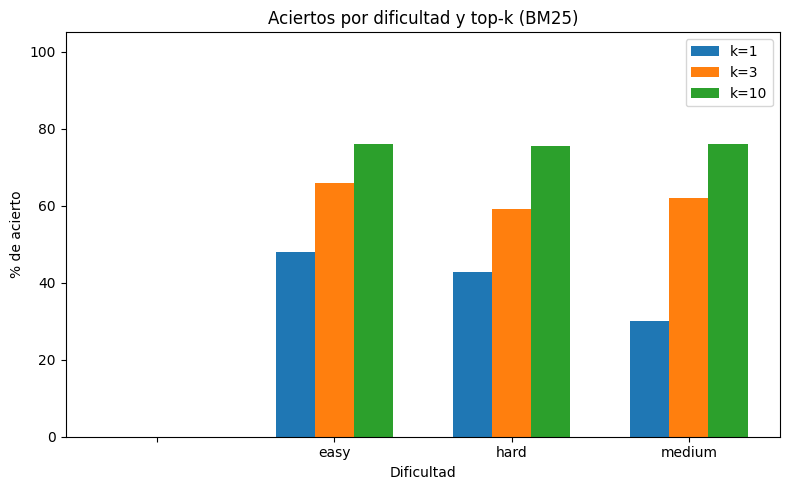

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

ks = [1, 3, 10]
resultados_k = []

for k in ks:
    dificultades = []
    aciertos = []
    for idx, qa in enumerate(qa_eval_set):
        dificultad = qa['dificultad']
        relevantes = set(qa['relevant_chunks'])
        recuperados = set(results_bm25.get(idx, [])[:k])
        acierto = int(len(recuperados & relevantes) > 0)
        dificultades.append(dificultad)
        aciertos.append(acierto)
    df = pd.DataFrame({'dificultad': dificultades, 'acierto': aciertos})
    tabla = df.groupby('dificultad').agg(
        total=('acierto', 'count'),
        aciertos=('acierto', 'sum')
    )
    tabla['% acierto'] = (tabla['aciertos'] / tabla['total'] * 100)
    tabla['k'] = k
    resultados_k.append(tabla.reset_index())

resultados_k = pd.concat(resultados_k)

# Gráfico: % de acierto por dificultad y por k
plt.figure(figsize=(8,5))
dificultades = resultados_k['dificultad'].unique()
bar_width = 0.22
x = np.arange(len(dificultades))

for i, k in enumerate(ks):
    subset = resultados_k[resultados_k['k'] == k]
    plt.bar(x + i*bar_width, subset['% acierto'], width=bar_width, label=f'k={k}')

plt.xticks(x + bar_width*(len(ks)-1)/2, dificultades)
plt.ylim(0, 105)
plt.ylabel('% de acierto')
plt.xlabel('Dificultad')
plt.title('Aciertos por dificultad y top-k (BM25)')
plt.legend()
plt.tight_layout()
plt.show()




### 3.2. SBERT MiniLM (FAISS)
Se utiliza el modelo SBERT MiniLM para generar embeddings de las queries y recuperar los top-k chunks más similares mediante búsqueda vectorial con FAISS.

In [128]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

model_minilm = SentenceTransformer("all-MiniLM-L6-v2")

embeddings_minilm = np.load("../data/embeddings/embeddings_minilm.npy")


In [ ]:
def recuperar_top_k_sbert(query, embeddings, model, k=10):
    query_emb = model.encode(query)
    scores = util.cos_sim(query_emb, embeddings)[0].cpu().numpy()
    top_idxs = np.argsort(scores)[::-1][:k]
    return list(top_idxs)

# tiempo de recuperación
results_minilm = {}
t0 = time.time()
for idx, qa in enumerate(qa_eval_set):
    query_text = qa['pregunta']
    top_idxs = recuperar_top_k_sbert(query_text, embeddings_minilm, model_minilm, k=10)
    results_minilm[idx] = top_idxs
t1 = time.time()

print(f"Tiempo total MiniLM: {t1 - t0:.2f}s, tiempo medio por query: {(t1 - t0)/len(qa_eval_set):.4f}s")



d:\TFM_RAG_NOR\venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Tiempo total MiniLM: 8.44s, tiempo medio por query: 0.0563s


In [130]:
summary_minilm, metrics_raw_minilm = evaluate_retrieval_metrics(
    results_minilm, relevant, chunk_metadata, k_list=[1,3,10]
)

# métricas globales
for k, metrics in summary_minilm.items():
    print(f"\nK={k}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.3f}")



K=1
  precision: 0.233
  recall: 0.233
  ndcg: 0.233
  map: 0.233
  mrr: 0.233
  pdf_match: 0.933

K=3
  precision: 0.380
  recall: 0.380
  ndcg: 0.315
  map: 0.293
  mrr: 0.293
  pdf_match: 0.987

K=10
  precision: 0.633
  recall: 0.633
  ndcg: 0.409
  map: 0.339
  mrr: 0.339
  pdf_match: 0.993


MiniLM rinde bastante peor que BM25 en todas las métricas principales, sobre todo en precisión y MRR. Los aciertos suben con k, pero aun así no llega al nivel de BM25. El pdf_match sigue siendo alto, pero encontrar el chunk relevante cuesta mucho más.


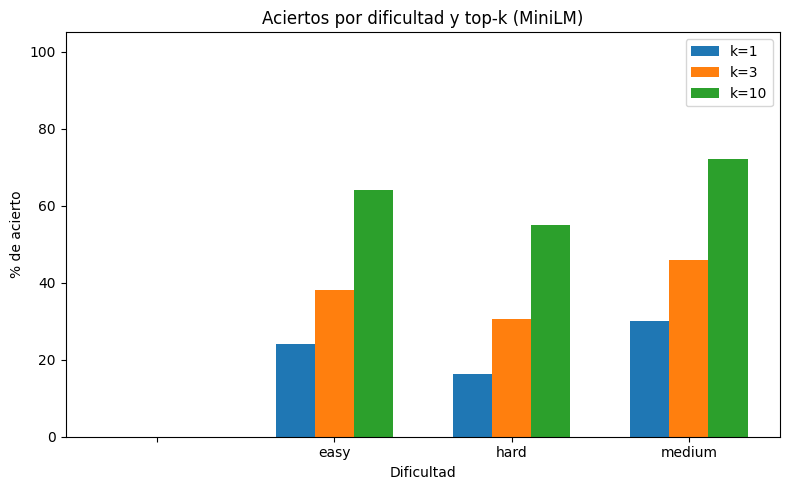

In [131]:
ks = [1, 3, 10]
resultados_k = []

for k in ks:
    dificultades = []
    aciertos = []
    for idx, qa in enumerate(qa_eval_set):
        dificultad = qa['dificultad']
        relevantes = set(qa['relevant_chunks'])
        recuperados = set(results_minilm.get(idx, [])[:k])
        acierto = int(len(recuperados & relevantes) > 0)
        dificultades.append(dificultad)
        aciertos.append(acierto)
    df = pd.DataFrame({'dificultad': dificultades, 'acierto': aciertos})
    tabla = df.groupby('dificultad').agg(
        total=('acierto', 'count'),
        aciertos=('acierto', 'sum')
    )
    tabla['% acierto'] = (tabla['aciertos'] / tabla['total'] * 100)
    tabla['k'] = k
    resultados_k.append(tabla.reset_index())

resultados_k = pd.concat(resultados_k)

# Gráfico: % de acierto por dificultad y por k
plt.figure(figsize=(8,5))
dificultades = resultados_k['dificultad'].unique()
bar_width = 0.22
x = np.arange(len(dificultades))

for i, k in enumerate(ks):
    subset = resultados_k[resultados_k['k'] == k]
    plt.bar(x + i*bar_width, subset['% acierto'], width=bar_width, label=f'k={k}')

plt.xticks(x + bar_width*(len(ks)-1)/2, dificultades)
plt.ylim(0, 105)
plt.ylabel('% de acierto')
plt.xlabel('Dificultad')
plt.title('Aciertos por dificultad y top-k (MiniLM)')
plt.legend()
plt.tight_layout()
plt.show()

### 3.3. SBERT MPNet (FAISS)
Se utiliza el modelo SBERT MPNet para generar embeddings de las queries y recuperar los top-k chunks más similares mediante búsqueda vectorial con FAISS.

In [133]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import time

# Cargar modelo y embeddings
model_mpnet = SentenceTransformer("all-mpnet-base-v2")
embeddings_mpnet = np.load("../data/embeddings/embeddings_mpnet.npy")

results_mpnet = {}
t0 = time.time()
for idx, qa in enumerate(qa_eval_set):
    query_text = qa['pregunta']
    query_emb = model_mpnet.encode(query_text)
    scores = util.cos_sim(query_emb, embeddings_mpnet)[0].cpu().numpy()
    top_idxs = np.argsort(scores)[::-1][:10]
    results_mpnet[idx] = list(top_idxs)
t1 = time.time()

print(f"Tiempo total MPNet: {t1 - t0:.2f}s, tiempo medio por query: {(t1 - t0)/len(qa_eval_set):.4f}s")


Tiempo total MPNet: 25.39s, tiempo medio por query: 0.1693s


In [135]:
summary_mpnet, metrics_raw_mpnet = evaluate_retrieval_metrics(
    results_mpnet, relevant, chunk_metadata, k_list=[1,3,10]
)

# Métricas globales
for k, metrics in summary_mpnet.items():
    print(f"\nK={k}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.3f}")



K=1
  precision: 0.313
  recall: 0.313
  ndcg: 0.313
  map: 0.313
  mrr: 0.313
  pdf_match: 0.953

K=3
  precision: 0.493
  recall: 0.493
  ndcg: 0.416
  map: 0.389
  mrr: 0.389
  pdf_match: 0.973

K=10
  precision: 0.713
  recall: 0.713
  ndcg: 0.496
  map: 0.428
  mrr: 0.428
  pdf_match: 0.993


In [136]:
k = 1  # Puedes cambiar el k que quieras analizar

# Listas para guardar casos interesantes
solo_bm25 = []   # Acierta BM25, falla MPNet
solo_mpnet = []  # Acierta MPNet, falla BM25
ninguno = []     # Ninguno acierta
ambos = []       # Ambos aciertan

for idx, qa in enumerate(qa_eval_set):
    relevantes = set(qa['relevant_chunks'])
    rec_bm25 = set(results_bm25.get(idx, [])[:k])
    rec_mpnet = set(results_mpnet.get(idx, [])[:k])
    acierto_bm25 = int(len(rec_bm25 & relevantes) > 0)
    acierto_mpnet = int(len(rec_mpnet & relevantes) > 0)

    if acierto_bm25 and not acierto_mpnet:
        solo_bm25.append(idx)
    elif acierto_mpnet and not acierto_bm25:
        solo_mpnet.append(idx)
    elif not acierto_bm25 and not acierto_mpnet:
        ninguno.append(idx)
    else:
        ambos.append(idx)

print(f"Acierta SOLO BM25: {len(solo_bm25)} queries")
print(f"Acierta SOLO MPNet: {len(solo_mpnet)} queries")
print(f"Aciertan ambos: {len(ambos)} queries")
print(f"Falla ambos: {len(ninguno)} queries")

n_mostrar = 5

for case, nombre in [(solo_bm25, 'Solo BM25 acierta'), (solo_mpnet, 'Solo MPNet acierta'), (ninguno, 'Ninguno acierta')]:
    print(f"\n--- {nombre} (muestra de {n_mostrar}) ---")
    for idx in case[:n_mostrar]:
        qa = qa_eval_set[idx]
        print(f"\nQuery idx: {idx}")
        print(f"Pregunta: {qa['pregunta']}")
        print(f"Dificultad: {qa['dificultad']}")
        print(f"Relevantes: {qa['relevant_chunks']}")
        print(f"BM25 top-{k}: {results_bm25[idx][:k]}")
        print(f"MPNet top-{k}: {results_mpnet[idx][:k]}")
        # Mostrar texto chunk relevante
        for cid in qa['relevant_chunks']:
            print(f"Texto chunk relevante:\n{chunk_texts[cid][:300]}...\n")
        # Mostrar texto del top-1 de cada método
        print(f"Texto chunk top-1 BM25:\n{chunk_texts[results_bm25[idx][0]][:300]}...\n")
        print(f"Texto chunk top-1 MPNet:\n{chunk_texts[results_mpnet[idx][0]][:300]}...\n")


Acierta SOLO BM25: 33 queries
Acierta SOLO MPNet: 20 queries
Aciertan ambos: 27 queries
Falla ambos: 70 queries

--- Solo BM25 acierta (muestra de 5) ---

Query idx: 0
Pregunta: What is the main advisory responsibility of the European Artificial Intelligence Board according to the regulation?
Dificultad: easy
Relevantes: [262]
BM25 top-1: [np.int64(262)]
MPNet top-1: [np.int64(336)]
Texto chunk relevante:
access to Testing and Experimentation Facilities to bodies, groups or laboratories established or accredited pursuant to any relevant Union harmonisation legislation and which fulfil tasks in the context of conformity assessment of products or devices covered by that Union harmonisation legislation....

Texto chunk top-1 BM25:
access to Testing and Experimentation Facilities to bodies, groups or laboratories established or accredited pursuant to any relevant Union harmonisation legislation and which fulfil tasks in the context of conformity assessment of products or devices covered by

### 3.4. Híbrido 
Se implementa un sistema híbrido que combina las puntuaciones de BM25 y embeddings (por ejemplo, mediante suma o producto normalizado) para recuperar los top-k resultados.

In [137]:
def hybrid_linear_combo(scores_bm25, scores_mpnet, alpha=0.5):
    # Normaliza ambos scores a [0,1]
    bm25_norm = (scores_bm25 - np.min(scores_bm25)) / (np.max(scores_bm25) - np.min(scores_bm25) + 1e-8)
    mpnet_norm = (scores_mpnet - np.min(scores_mpnet)) / (np.max(scores_mpnet) - np.min(scores_mpnet) + 1e-8)
    # Combinación lineal ponderada
    hybrid_score = alpha * bm25_norm + (1 - alpha) * mpnet_norm
    return hybrid_score


In [138]:
def hybrid_log_geometric(scores_bm25, scores_mpnet, alpha=0.5):
    # Normaliza ambos a [0,1] y evita log(0)
    bm25_norm = (scores_bm25 - np.min(scores_bm25)) / (np.max(scores_bm25) - np.min(scores_bm25) + 1e-8) + 1e-8
    mpnet_norm = (scores_mpnet - np.min(scores_mpnet)) / (np.max(scores_mpnet) - np.min(scores_mpnet) + 1e-8) + 1e-8
    # Log-weighted producto geométrico
    hybrid_score = np.exp(alpha * np.log(bm25_norm) + (1 - alpha) * np.log(mpnet_norm))
    return hybrid_score


In [143]:
k = 10
alphas = [0.1,0.2,0.3, 0.5, 0.7]

results_hybrid_linear_alphas = {}
results_hybrid_log_alphas = {}

for alpha in alphas:
    results_hybrid_linear = {}
    results_hybrid_log = {}
    for idx, qa in enumerate(qa_eval_set):
        query_text = qa['pregunta']
        # BM25
        scores_bm25 = bm25_index.get_scores(query_text.split())
        # MPNet
        query_emb = model_mpnet.encode(query_text)
        scores_mpnet = util.cos_sim(query_emb, embeddings_mpnet)[0].cpu().numpy()
        # Linear Combo
        scores_lin = hybrid_linear_combo(scores_bm25, scores_mpnet, alpha=alpha)
        top_idxs_lin = np.argsort(scores_lin)[::-1][:k]
        results_hybrid_linear[idx] = list(top_idxs_lin)
        # Log-Weighted
        scores_log = hybrid_log_geometric(scores_bm25, scores_mpnet, alpha=alpha)
        top_idxs_log = np.argsort(scores_log)[::-1][:k]
        results_hybrid_log[idx] = list(top_idxs_log)
    results_hybrid_linear_alphas[alpha] = results_hybrid_linear
    results_hybrid_log_alphas[alpha] = results_hybrid_log

print("Listo.")



Listo.


In [146]:
summary_hybrid_linear, metrics_raw_hybrid_linear = evaluate_retrieval_metrics(
    results_hybrid_linear, relevant, chunk_metadata, k_list=[1,3,10]
)

summary_hybrid_log, metrics_raw_hybrid_log = evaluate_retrieval_metrics(
    results_hybrid_log, relevant, chunk_metadata, k_list=[1,3,10]
)

for alpha in alphas:
    print(f"\n--- Resultados Hybrid Linear Combo (alpha={alpha}) ---")
    summary, metrics = evaluate_retrieval_metrics(
        results_hybrid_linear_alphas[alpha], relevant, chunk_metadata, k_list=[1,3,10]
    )
    for k, valores in summary.items():
        print(f"K={k}")
        for metric, value in valores.items():
            print(f"  {metric}: {value:.3f}")

for alpha in alphas:
    print(f"\n--- Resultados Hybrid Log-Weighted (alpha={alpha}) ---")
    summary, metrics = evaluate_retrieval_metrics(
        results_hybrid_log_alphas[alpha], relevant, chunk_metadata, k_list=[1,3,10]
    )
    for k, valores in summary.items():
        print(f"K={k}")
        for metric, value in valores.items():
            print(f"  {metric}: {value:.3f}")



--- Resultados Hybrid Linear Combo (alpha=0.1) ---
K=1
  precision: 0.387
  recall: 0.387
  ndcg: 0.387
  map: 0.387
  mrr: 0.387
  pdf_match: 0.960
K=3
  precision: 0.593
  recall: 0.593
  ndcg: 0.507
  map: 0.477
  mrr: 0.477
  pdf_match: 0.987
K=10
  precision: 0.780
  recall: 0.780
  ndcg: 0.575
  map: 0.510
  mrr: 0.510
  pdf_match: 0.993

--- Resultados Hybrid Linear Combo (alpha=0.2) ---
K=1
  precision: 0.433
  recall: 0.433
  ndcg: 0.433
  map: 0.433
  mrr: 0.433
  pdf_match: 0.953
K=3
  precision: 0.627
  recall: 0.627
  ndcg: 0.545
  map: 0.517
  mrr: 0.517
  pdf_match: 0.993
K=10
  precision: 0.840
  recall: 0.840
  ndcg: 0.623
  map: 0.555
  mrr: 0.555
  pdf_match: 0.993

--- Resultados Hybrid Linear Combo (alpha=0.3) ---
K=1
  precision: 0.460
  recall: 0.460
  ndcg: 0.460
  map: 0.460
  mrr: 0.460
  pdf_match: 0.953
K=3
  precision: 0.647
  recall: 0.647
  ndcg: 0.568
  map: 0.541
  mrr: 0.541
  pdf_match: 0.993
K=10
  precision: 0.880
  recall: 0.880
  ndcg: 0.657
  ma

In [147]:
sistemas = {
    'BM25': summary_bm25,
    'MiniLM': summary_minilm,
    'MPNet': summary_mpnet,
    'Hybrid Linear (a=0.3)': evaluate_retrieval_metrics(
        results_hybrid_linear_alphas[0.3], relevant, chunk_metadata, k_list=[1,3,10]
    )[0],
    'Hybrid Log (a=0.3)': evaluate_retrieval_metrics(
        results_hybrid_log_alphas[0.3], relevant, chunk_metadata, k_list=[1,3,10]
    )[0]
}

ks = [1, 3, 10]
metrica = 'precision'  # Puedes cambiar a 'ndcg', 'mrr', etc.

datos = {nombre: [sistemas[nombre][k][metrica] for k in ks] for nombre in sistemas}


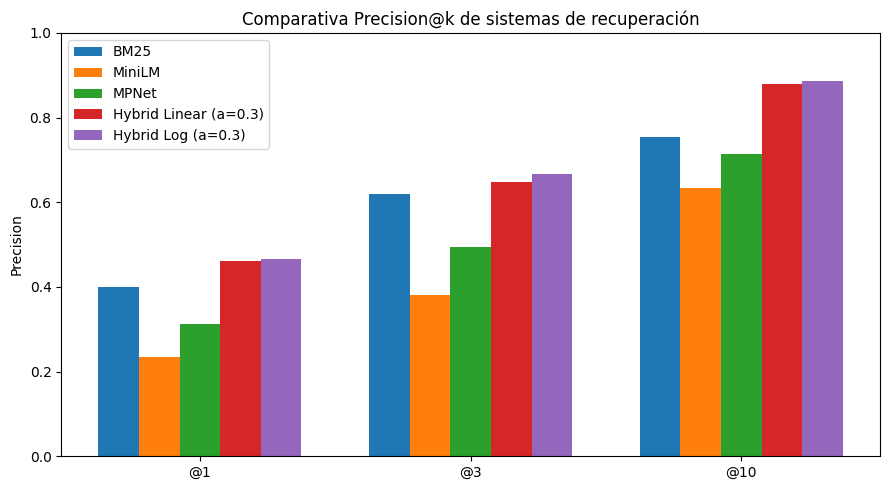

In [148]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,5))
bar_width = 0.15
x = np.arange(len(ks))

for i, (nombre, vals) in enumerate(datos.items()):
    plt.bar(x + i*bar_width, vals, width=bar_width, label=nombre)

plt.xticks(x + bar_width*2, [f'@{k}' for k in ks])
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.title('Comparativa Precision@k de sistemas de recuperación')
plt.legend()
plt.tight_layout()
plt.show()


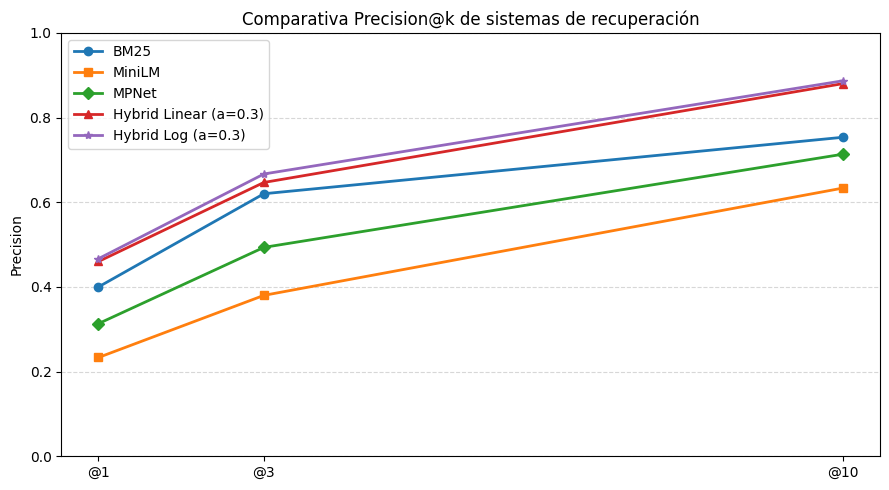

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
ks = [1, 3, 10]
markers = ['o', 's', 'D', '^', '*']

for i, (nombre, vals) in enumerate(datos.items()):
    plt.plot(ks, vals, marker=markers[i], label=nombre, linewidth=2)

plt.xticks(ks, [f'@{k}' for k in ks])
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.title('Comparativa Precision@k de sistemas de recuperación')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [150]:
sistemas_export = ['BM25', 'MiniLM', 'MPNet', 'Hybrid Linear (a=0.3)', 'Hybrid Log (a=0.3)']
metricas_export = ['precision', 'ndcg', 'mrr', 'map', 'pdf_match']
rows = []

for sistema in sistemas_export:
    for k in ks:
        entry = {
            'Sistema': sistema,
            'K': k
        }
        metrics_k = sistemas[sistema][k]
        for metrica in metricas_export:
            entry[metrica] = metrics_k[metrica]
        rows.append(entry)

df_global = pd.DataFrame(rows)
df_global.to_csv('resultados_metricas_globales.csv', index=False)
print("Exportado como 'resultados_metricas_globales.csv'")


Exportado como 'resultados_metricas_globales.csv'


In [151]:
resultados_dificultad = []

for sistema, results in zip(
        sistemas_export,
        [results_bm25, results_minilm, results_mpnet,
         results_hybrid_linear_alphas[0.3], results_hybrid_log_alphas[0.3]]):
    for k in ks:
        dificultades = []
        aciertos = []
        for idx, qa in enumerate(qa_eval_set):
            dificultad = qa['dificultad']
            relevantes = set(qa['relevant_chunks'])
            recuperados = set(results.get(idx, [])[:k])
            acierto = int(len(recuperados & relevantes) > 0)
            dificultades.append(dificultad)
            aciertos.append(acierto)
        df = pd.DataFrame({'dificultad': dificultades, 'acierto': aciertos})
        tabla = df.groupby('dificultad').agg(
            total=('acierto', 'count'),
            aciertos=('acierto', 'sum')
        )
        tabla['% acierto'] = (tabla['aciertos'] / tabla['total'] * 100)
        tabla['Sistema'] = sistema
        tabla['K'] = k
        resultados_dificultad.append(tabla.reset_index())

df_dificultad = pd.concat(resultados_dificultad, ignore_index=True)
df_dificultad.to_csv('resultados_por_dificultad.csv', index=False)
print("Exportado como 'resultados_por_dificultad.csv'")


Exportado como 'resultados_por_dificultad.csv'


In [ ]:
export_rows = []
for idx, qa in enumerate(qa_eval_set):
    relevantes = set(qa['relevant_chunks'])
    recuperados = results_bm25.get(idx, [])[:10]
    acierto = int(len(set(recuperados) & relevantes) > 0)
    # posición del relevante
    pos_relevante = next((i+1 for i, c in enumerate(recuperados) if c in relevantes), None)
    export_rows.append({
        'query_id': idx,
        'dificultad': qa['dificultad'],
        'acierto': acierto,
        'pos_relevante': pos_relevante
    })

df_query = pd.DataFrame(export_rows)
df_query.to_csv('resultados_query_bm25.csv', index=False)
print("Exportado resultados query a query (BM25)")


Exportado resultados query a query (BM25)


---

## 4. Conclusiones de resultados

Los resultados dejan claro que BM25 rinde mejor que los modelos de embeddings puros (MiniLM, MPNet) en este corpus, sobre todo en precisión y acierto exacto. Esto probablemente se debe a que las preguntas del benchmark se parecen bastante al texto literal de los documentos, lo que da mucha ventaja a BM25 en la recuperación por palabras clave. MiniLM es el que peor funciona, mientras que MPNet mejora un poco pero sigue lejos de BM25.

Lo más interesante es que el sistema híbrido (combinando BM25 y embeddings) consigue superar a todos en las métricas clave cuando el peso de BM25 no es demasiado alto (alpha ≈ 0.3). Da la sensación de que la mezcla equilibra bien la literalidad de BM25 con la capacidad de los embeddings para captar semántica, aunque estos por sí solos no bastan. El pico en alpha bajo confirma que sumar una pequeña parte de señal semántica ayuda a corregir los fallos de BM25 en casos menos literales, pero si el peso de BM25 es demasiado alto o bajo, el rendimiento vuelve a bajar.

En resumen: BM25 domina en literalidad, los embeddings ayudan en semántica, y la combinación de ambos (bien calibrada) es lo que saca el máximo partido en este tipo de corpus normativo.
